In [3]:
import pysal

/home/hcchen/anaconda3/envs/emb-geometry/lib/python2.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [61]:
import os
import operator
import pandas as pd
import pickle
import random
import sklearn
import powerlaw
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from gensim.models import Word2Vec, KeyedVectors
from scipy.io import loadmat, savemat
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity

sns.set()

In [5]:
from sklearn import random_projection
from sklearn.manifold import TSNE
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, spdiags

In [6]:
%matplotlib inline

In [7]:
%load_ext autoreload
%autoreload 2

# Run DeepWalk

Run the following command in shell:

In [ ]:
nohup time deepwalk --format mat --input /home/hcchen/emb-geometry/ba-n=10000-m=20.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 20 --output /home/hcchen/emb-geometry/ba-n=10000-m=20.mat &

# Construct a Preferential Attachment Graph

## Small One

In [43]:
n = 2000
m = 20
G = nx.barabasi_albert_graph(n, m, seed=42)
A = nx.to_scipy_sparse_matrix(G)
savemat('ba-n=%d-m=%d.mat' % (n, m), {'network': nx.to_scipy_sparse_matrix(G)})

In [44]:
d = np.asarray([int(d) for node, d in G.degree])

('alpha= ', 1.2384415556528208, '  sigma= ', 0.005331715271005065)


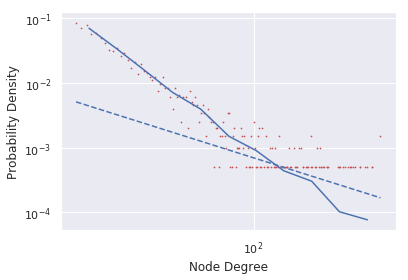

In [45]:
import powerlaw
fit = powerlaw.Fit(d, xmin=1, discrete=True)
x, y = powerlaw.pdf(d, linear_bins=True)
ind = y>0
y = y[ind]
x = x[:-1]
x = x[ind]

plt.scatter(x, y, color='r', s=.5)
fit.power_law.plot_pdf(color= 'b',linestyle='--',label='fit ccdf')
fit.plot_pdf(color= 'b')
plt.xlabel('Node Degree')
plt.ylabel('Probability Density')
# plt.savefig('text8-wordfreq.pdf')

print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

In [ ]:
python3 src/randne.py --input /home/hcchen/emb-geometry/ba-n=2000-m=20.mat \
--output /home/hcchen/emb-geometry/rp-ba-n=2000-m=20.mat -q 3 -d 128 --weights 1 0.01 0.001

In [52]:
rp_emb = loadmat('/home/hcchen/emb-geometry/rp-ba-n=2000-m=20.mat')['emb']
%time rp_emb_w = pysal.weights.util.full2W(cosine_similarity(rp_emb, rp_emb))

CPU times: user 2.2 s, sys: 923 ms, total: 3.12 s
Wall time: 2.61 s


In [53]:
%time mi = pysal.Moran(d, rp_emb_w, two_tailed=False)

CPU times: user 16.4 s, sys: 683 ms, total: 17.1 s
Wall time: 24.9 s


In [54]:
mi.I

0.00013367857522017163

In [55]:
mi.EI

-0.0005002501250625312

In [57]:
'%.5f' % mi.p_norm

'0.00000'

In [ ]:
nohup time deepwalk --format mat --input /home/hcchen/emb-geometry/ba-n=2000-m=20.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 20 --output /home/hcchen/emb-geometry/ba-n=2000-m=20.emb &

In [66]:
dw_model = KeyedVectors.load_word2vec_format('/home/hcchen/emb-geometry/ba-n=2000-m=20.emb')
N = len(dw_model.vocab)
dw_emb = np.asarray([dw_model[str(node)] for node in range(N)])

In [68]:
%time dw_emb_w = pysal.weights.util.full2W(cosine_similarity(dw_emb, dw_emb))

CPU times: user 1.97 s, sys: 1.19 s, total: 3.16 s
Wall time: 1.89 s


In [69]:
%time mi = pysal.Moran(d, dw_emb_w, two_tailed=False)

CPU times: user 33.6 s, sys: 641 ms, total: 34.2 s
Wall time: 34.7 s


In [70]:
mi.I

0.002874369182722769

In [71]:
mi.EI

-0.0005002501250625312

In [72]:
mi.p_norm

1.82609901903108e-05

## Large One

In [76]:
n = 10000
m = 20
G = nx.barabasi_albert_graph(n, m, seed=42)

In [105]:
G.number_of_nodes()

10000

In [78]:
G.number_of_edges()

199600

In [79]:
A = nx.to_scipy_sparse_matrix(G)

In [56]:
savemat('ba-n=%d-m=%d.mat' % (n, m), {'network': nx.to_scipy_sparse_matrix(G)})

Save as a .mat file:

In [80]:
d = np.asarray([int(d) for node, d in G.degree])

('alpha= ', 1.2388343643055604, '  sigma= ', 0.002388343643055604)


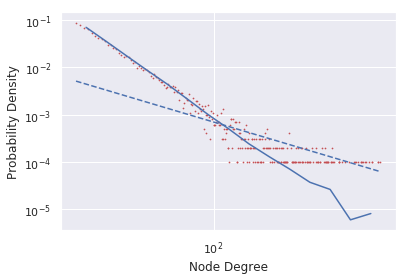

In [16]:
import powerlaw
fit = powerlaw.Fit(d, xmin=1, discrete=True)
x, y = powerlaw.pdf(d, linear_bins=True)
ind = y>0
y = y[ind]
x = x[:-1]
x = x[ind]

plt.scatter(x, y, color='r', s=.5)
fit.power_law.plot_pdf(color= 'b',linestyle='--',label='fit ccdf')
fit.plot_pdf(color= 'b')
plt.xlabel('Node Degree')
plt.ylabel('Probability Density')
# plt.savefig('text8-wordfreq.pdf')

print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

## Random Projection on BA Graph

In [ ]:
python3 src/randne.py --input /home/hcchen/emb-geometry/ba-n=10000-m=20.mat \
--output /home/hcchen/emb-geometry/rp-ba-n=10000-m=20.mat -q 3 -d 128 --weights 1 0.01 0.001

Load the embeddings:

In [73]:
rp_emb = loadmat('/home/hcchen/emb-geometry/rp-ba-n=10000-m=20.mat')['emb']

In [74]:
%time rp_emb_w = pysal.weights.util.full2W(cosine_similarity(rp_emb, rp_emb))

CPU times: user 30.8 s, sys: 5.83 s, total: 36.6 s
Wall time: 34.1 s


In [81]:
%time mi = pysal.Moran(d, rp_emb_w, two_tailed=False)

CPU times: user 3min 57s, sys: 10.6 s, total: 4min 8s
Wall time: 4min 8s


In [82]:
mi.I

7.977332197853172e-05

In [83]:
mi.EI

-0.00010001000100010001

In [84]:
"%.5f" % mi.p_norm

'0.00000'

## DeepWalk on BA Graph

We run this command (in shell):

In [ ]:
nohup time deepwalk --format mat --input /home/hcchen/emb-geometry/ba-n=10000-m=20.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 20 --output /home/hcchen/emb-geometry/ba-n=10000-m=20.emb &

Then load the embeddings:

In [86]:
dw_model = KeyedVectors.load_word2vec_format('/home/hcchen/emb-geometry/ba-n=10000-m=20.emb')
N = len(dw_model.vocab)
dw_emb = np.asarray([dw_model[str(node)] for node in range(N)])

In [89]:
%time dw_emb_w = pysal.weights.util.full2W(cosine_similarity(dw_emb, dw_emb))

CPU times: user 38.4 s, sys: 10.2 s, total: 48.6 s
Wall time: 45.3 s


In [90]:
%time mi = pysal.Moran(d, dw_emb_w, two_tailed=False)

CPU times: user 11min 5s, sys: 20.5 s, total: 11min 26s
Wall time: 11min 26s


In [91]:
mi.I

0.0004437254504801698

In [92]:
mi.EI

-0.00010001000100010001

In [93]:
"%.5f" % mi.p_norm

'0.00085'

# Glove

Load embeddings and frequencies:

In [95]:
def load_glove(glove_file):
    print ('Loading Glove Model')
    f = open(glove_file, 'r')
    words, embs = [], []
    for line in f:
        split_line = line.split(' ')
        word = split_line[0]
        words.append(word)
        emb = np.array([float(val) for val in split_line[1:]])
        embs.append(emb)
    print ('Done.', len(words), 'words loaded!')
    return words, np.asarray(embs)

In [96]:
%time words, glove_embs = load_glove('glove.text8.50d.70k.txt')

Loading Glove Model
('Done.', 71291, 'words loaded!')
CPU times: user 2.07 s, sys: 88 ms, total: 2.16 s
Wall time: 2.17 s


In [23]:
lat2W_4 = pysal.lat2W(4,4)

In [26]:
lat2W_4.full()

(array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

In [97]:
freq_map = {}
glove_freq = []
with open('glove.text8.vocab.txt') as fp:
    for line in fp:
        word, freq = line.split(' ')
        glove_freq.append(int(freq.strip()))
        freq_map[word] = int(freq.strip())

Use a frequency filter here:

In [98]:
len([word for word in words if word in freq_map and freq_map[word] >= 100])

11815

In [99]:
N = 11815
glove_embs_N = glove_embs[:N]
glove_freq_N = glove_freq[:N]

In [100]:
%time glove_emb_w = pysal.weights.util.full2W(cosine_similarity(glove_embs_N, glove_embs_N))

CPU times: user 40.6 s, sys: 8.83 s, total: 49.5 s
Wall time: 44.1 s


Compute spatial autocorrelation stats:

In [47]:
%time mi = pysal.Moran(glove_freq_N, glove_emb_w, two_tailed=False)

CPU times: user 6min 16s, sys: 18.8 s, total: 6min 35s
Wall time: 6min 35s


In [48]:
mi.I

0.006873175363268437

In [49]:
mi.EI

-8.464533604198409e-05

In [50]:
"%.5f" % mi.p_norm

'0.37706'

Or use the log of frequency count?

In [101]:
%time mi = pysal.Moran(map(math.log, glove_freq_N), glove_emb_w, two_tailed=False)

CPU times: user 6min 25s, sys: 31.2 s, total: 6min 56s
Wall time: 6min 56s


In [102]:
mi.I

0.5399524593349561

In [103]:
mi.EI

-8.464533604198409e-05

In [104]:
"%.5f" % mi.p_norm

'0.00000'